In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
##read datasets
df=pd.read_pickle(r"cust_final_20191030.pkl")

In [3]:
df.columns 

Index(['MOBILE', 'PRODUCT_GROUP', 'MEMBER_ID_nunique', 'ACTIVITY_ID_nunique',
       'ACTIVITY_VALUE_max', 'ACTIVITY_VALUE_min', 'ACTIVITY_VALUE_median',
       'ACTIVITY_VALUE_std', 'ACTIVITY_VALUE_mean', 'ALLOCATED_POINTS_max',
       ...
       'CLIENT_EXI_3M', 'TIME_DECISION_DATE', 'RISK_FPD30', 'RISK_AGRF30',
       'RISK_FSPD30', 'RISK_AGRF60', 'RISK_FSTPD30', 'RISK_AGRF90',
       'RISK_FSTQPD30', 'RISK_AGRF120'],
      dtype='object', length=477)

In [4]:
df.dropna(subset=['HC_SCORE'],inplace=True)
df = df[(df['RISK_AGRF120']== 1) & (df['PRODUCT_GROUP']=='CD')]

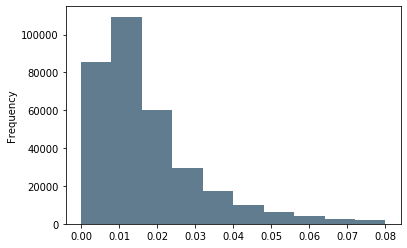

In [5]:
# Check distribution of scores
pd.Series(df['HC_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [6]:
X=df.drop(['MOBILE','RISK_AGRF30','RISK_FPD30','RISK_FSPD30','RISK_FSTPD30',
           'RISK_FSTQPD30','CLIENT_EXI_3M','PRODUCT_GROUP', 'TIME_DECISION_DATE_max', 'ACTIVITY_DATE_min', 'ACTIVITY_DATE_max', 
            'TIME_DECISION_DATE'] ,axis=1)
Y=df[['RISK_FSTQPD30']]

In [7]:
hcc_score='HC_SCORE'

# HCC score Gini         
y_hcc = X[hcc_score]
df_hcc = pd.DataFrame({'true': np.ravel(Y), 'predict': y_hcc})
df_hcc = df_hcc.loc[pd.notnull(df_hcc['predict']),:]
metric_auc_hcc = metrics.roc_auc_score(df_hcc['true'], df_hcc['predict'])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.21925967724797402


In [8]:
# split data into train and test sets
seed = 25522
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# X_train.drop('UW_SC',axis=1,inplace=True) 
# X_test.drop('UW_SC',axis=1,inplace=True) 

##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train.iloc[:,0]) / len(y_train.iloc[:,0])))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test.iloc[:,0]) / len(y_test.iloc[:,0])))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid.iloc[:,0]) / len(y_valid.iloc[:,0])))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['HC_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['HC_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['HC_SCORE'])*2 -1)

## fecth original test data
train,test = train_test_split(df, test_size=test_size, random_state=seed)
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(train['RISK_FSTQPD30']) / len(train.iloc[:,0])))
print("\n Train set shape:",train.shape)
print("\n Train GINI",  metrics.roc_auc_score(train['RISK_FSTQPD30'], train['HC_SCORE'])*2 -1)

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(test['RISK_FSTQPD30']) / len(test.iloc[:,0])))
print("\n test set shape:",test.shape)
print("\n test GINI",  metrics.roc_auc_score(test['RISK_FSTQPD30'], test['HC_SCORE'])*2 -1)


Event rate in train set : 3.59%

 Train set shape: (186744, 465)

Event rate in test set : 3.65%

 Test set shape: (100043, 465)

Event rate in validation set : 3.60%

 validation set shape: (46687, 465)

 Train GINI 0.22148714013446136

 Test GINI 0.20868546620931272

 validation GINI 0.23352214399219218

Event rate in train set : 3.59%

 Train set shape: (233431, 477)

 Train GINI 0.2238763190910209

Event rate in test set : 3.65%

 test set shape: (100043, 477)

 test GINI 0.20868546620931272


In [9]:
#X_test_pkl = X_test
#X_test_pkl['RISK_FSTQPD30'] = y_test
#X_test_pkl.to_pickle("cd\\pillar_test_set.pkl")

In [10]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [11]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='HC_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='HC_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='HC_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [12]:
imp = fimportances(bst,X_train.drop(columns='HC_SCORE').columns)

In [13]:
bst1 = bst
X_train_1 = X_train.drop(columns='HC_SCORE')
X_valid_1 = X_valid.drop(columns='HC_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 1):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 260 , gini_train: 0.276004,gini_test: 0.257885 
Columns Remaining : 217 , gini_train: 0.275919,gini_test: 0.259656 
Columns Remaining : 193 , gini_train: 0.261543,gini_test: 0.255021 
Columns Remaining : 160 , gini_train: 0.277203,gini_test: 0.259655 
Columns Remaining : 153 , gini_train: 0.275265,gini_test: 0.258602 
Columns Remaining : 147 , gini_train: 0.277457,gini_test: 0.259639 
Columns Remaining : 144 , gini_train: 0.276632,gini_test: 0.259661 
Columns Remaining : 140 , gini_train: 0.276716,gini_test: 0.260735 
Columns Remaining : 136 , gini_train: 0.276412,gini_test: 0.260219 
Columns Remaining : 130 , gini_train: 0.275187,gini_test: 0.259265 
Columns Remaining : 126 , gini_train: 0.274669,gini_test: 0.257847 
Columns Remaining : 121 , gini_train: 0.274656,gini_test: 0.258353 
Columns Remaining : 117 , gini_train: 0.275682,gini_test: 0.260392 
Columns Remaining : 114 , gini_train: 0.274569,gini_test: 0.259766 
Columns Remaining : 110 , gini_train: 0.274960,g

In [14]:
df_imp =pd.DataFrame(dic_imp)

In [15]:
list(df_imp[df_imp['n']==34]["Predictors"])

[['ALLOCATED_POINTS_std',
  'ALLOCATED_POINTS_EARN_LAG2',
  'ACTIVITY_ID_nunique',
  'ALLOCATED_POINTS_EARN_LAG1',
  'mesdq_max',
  'month_nunique_FUEL_1000_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'month_nunique_DEBIT_1000_Earn',
  'ACTIVITY_VALUE_std',
  'month_nunique_DEBIT_180_Earn',
  'month_nunique_GROCERY_1000_Earn',
  'month_nunique_DEBIT_365_Earn',
  'month_nunique_DEBIT_90_Earn',
  'month_nunique_E_WALLET_365_by_1000_Earn',
  'ACTIVITY_ID_count_DEBIT_180_Earn',
  'month_nunique_FUEL_365_Earn',
  'month_nunique_FUEL_180_by_1000_Earn',
  'month_nunique_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_sum_E_WALLET_365_by_1000_Earn',
  'ACTIVITY_ID_count_FUEL_1000_Earn',
  'MOB',
  'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_max_FUEL_180_Earn',
  'ACTIVITY_DATE_nunique_E_WALLET_365_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_180_by_1000_Earn',
  'ALLOCATED_POINTS_std_DEBIT_90_Earn',
  'ALLOCATED_POINTS_median_DEBIT_90_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_365_by_1000_Earn

In [16]:
selected_vars = list(df_imp[df_imp['n']==34]["Predictors"])

In [17]:
selected_vars

[['ALLOCATED_POINTS_std',
  'ALLOCATED_POINTS_EARN_LAG2',
  'ACTIVITY_ID_nunique',
  'ALLOCATED_POINTS_EARN_LAG1',
  'mesdq_max',
  'month_nunique_FUEL_1000_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'month_nunique_DEBIT_1000_Earn',
  'ACTIVITY_VALUE_std',
  'month_nunique_DEBIT_180_Earn',
  'month_nunique_GROCERY_1000_Earn',
  'month_nunique_DEBIT_365_Earn',
  'month_nunique_DEBIT_90_Earn',
  'month_nunique_E_WALLET_365_by_1000_Earn',
  'ACTIVITY_ID_count_DEBIT_180_Earn',
  'month_nunique_FUEL_365_Earn',
  'month_nunique_FUEL_180_by_1000_Earn',
  'month_nunique_DEBIT_90_by_1000_Earn',
  'ALLOCATED_POINTS_sum_E_WALLET_365_by_1000_Earn',
  'ACTIVITY_ID_count_FUEL_1000_Earn',
  'MOB',
  'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_max_FUEL_180_Earn',
  'ACTIVITY_DATE_nunique_E_WALLET_365_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_180_by_1000_Earn',
  'ALLOCATED_POINTS_std_DEBIT_90_Earn',
  'ALLOCATED_POINTS_median_DEBIT_90_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_365_by_1000_Earn

In [18]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]


print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (186744, 34) 
 Test shape: (100043, 34) 
 Validation shape: (46687, 34)


In [19]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1)

In [21]:
## XGB model##
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 2)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=100,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 2456.6406791210175
Best score: 0.6309039612535026
Best params: 
colsample_bytree: 0.7000000000000002
learning_rate: 0.016
max_depth: 5
min_child_weight: 4
scale_pos_weight: 15
subsample: 0.6


In [55]:
pd.Series(dic['mean_train_roc_auc']).to_csv("mean_train_roc_auc_cd.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [56]:
pd.Series(dic['mean_test_roc_auc']).to_csv("mean_test_roc_auc_cd.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [60]:
pd.DataFrame(dic['params']).to_csv("params.csv")

In [26]:
# colsample_bytree: 0.7000000000000002
# learning_rate: 0.016
# max_depth: 5
# min_child_weight: 10
# scale_pos_weight: 5
# subsample: 0.6pd.DataFrame(dic['params']).to_csv("params_mesdq.csv")

In [20]:

#First Run
xgb_model = xgb.XGBClassifier(max_depth = 1,
              learning_rate= 0.019,
              subsample= 0.65,
              min_child_weight= 16,
              colsample_bytree= 0.7,
              scale_pos_weight =27,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [21]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [22]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [23]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.22036067578978802

GINI Validation: 0.224045881544936

GINI CV: 0.21194578598236005


In [24]:
X_train_2.columns

Index(['ALLOCATED_POINTS_std', 'ALLOCATED_POINTS_EARN_LAG2',
       'ACTIVITY_ID_nunique', 'ALLOCATED_POINTS_EARN_LAG1', 'mesdq_max',
       'month_nunique_FUEL_1000_Earn', 'ALLOCATED_POINTS_EARN_LAG3',
       'month_nunique_DEBIT_1000_Earn', 'ACTIVITY_VALUE_std',
       'month_nunique_DEBIT_180_Earn', 'month_nunique_GROCERY_1000_Earn',
       'month_nunique_DEBIT_365_Earn', 'month_nunique_DEBIT_90_Earn',
       'month_nunique_E_WALLET_365_by_1000_Earn',
       'ACTIVITY_ID_count_DEBIT_180_Earn', 'month_nunique_FUEL_365_Earn',
       'month_nunique_FUEL_180_by_1000_Earn',
       'month_nunique_DEBIT_90_by_1000_Earn',
       'ALLOCATED_POINTS_sum_E_WALLET_365_by_1000_Earn',
       'ACTIVITY_ID_count_FUEL_1000_Earn', 'MOB',
       'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',
       'ALLOCATED_POINTS_max_FUEL_180_Earn',
       'ACTIVITY_DATE_nunique_E_WALLET_365_Earn',
       'ACTIVITY_DATE_nunique_DEBIT_180_by_1000_Earn',
       'ALLOCATED_POINTS_std_DEBIT_90_Earn',
       'ALLOCATED_POINT

In [25]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.2265843506130394


In [26]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(r"xgb_cd_fstq_varimp.csv",index=0)

In [27]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.head(50)

,predictor,importance
0,ALLOCATED_POINTS_EARN_LAG1,0.140363
1,ALLOCATED_POINTS_EARN_LAG2,0.093281
2,ACTIVITY_VALUE_std,0.082379
3,ALLOCATED_POINTS_std,0.076049
4,mesdq_max,0.072812
5,month_nunique_DEBIT_1000_Earn,0.069885
6,ALLOCATED_POINTS_EARN_LAG3,0.064864
7,month_nunique_FUEL_1000_Earn,0.064759
8,month_nunique_DEBIT_90_Earn,0.061830
9,month_nunique_DEBIT_180_Earn,0.052056


In [28]:
## save the model 
pickle.dump(bst, open("xgb_cd_fstq_wo_hc.mod", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(r"xgb_cd_fstq_wohc.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


[[91920  4476]
 [ 3123   524]]

 Log Loss is : 0.6806468858930783
Average precision-recall score: 0.05


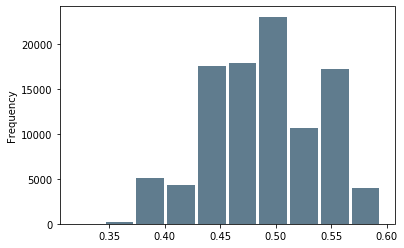

In [29]:
#metrics calculation
cutoff=np.percentile(X_test['HC_SCORE'],95)
ypred=pd.Series(X_test['HC_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [30]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

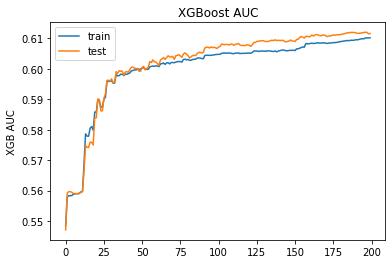

In [31]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

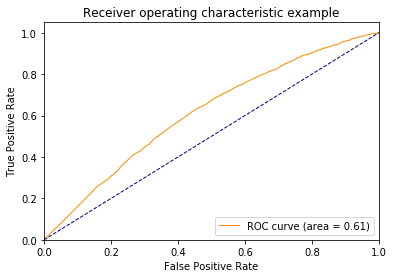

In [32]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.iloc[:, 0].ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[]

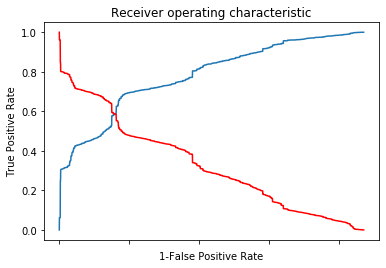

In [33]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [34]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.49833655


In [35]:
print(" \n Min -Max test score:",test['HC_SCORE'].min(),"\t",test['HC_SCORE'].max())
print(" \n Min -Max train score:",train['HC_SCORE'].min(),"\t",train['HC_SCORE'].max())

 
 Min -Max test score: 0.000375347076813848 	 0.5046075807869808
 
 Min -Max train score: 0.0002987409422098748 	 0.5226301025062391


In [36]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 12025
Bad captured in worst category : 22.00%

                       HC_SCORE  RISK_FSTQPD30
HC_SCORE                                     
(-0.000701, 0.00459]  0.003169       0.016853
(0.00459, 0.0068]     0.005717       0.025849
(0.0068, 0.00886]     0.007845       0.027709
(0.00886, 0.0111]     0.009993       0.031276
(0.0111, 0.0136]      0.012343       0.031247
(0.0136, 0.0166]      0.015045       0.033406
(0.0166, 0.0205]      0.018447       0.034773
(0.0205, 0.0266]      0.023292       0.037419
(0.0266, 0.039]       0.031791       0.042762
(0.039, 0.523]        0.064769       0.079315
                         HC_SCORE  RISK_FSTQPD30
HC_SCORE                                        
(-0.000701, 0.00459]   105.672953            562
(0.00459, 0.0068]      190.635348            862
(0.0068, 0.00886]      261.617700            924
(0.00886, 0.0111]      333.252230           1043
(0.0111, 0.0136]       411.609848           1042
(0.0136, 0.0166]       501.703839           

In [37]:
## Bad rates in overall population 
cd=pd.DataFrame(test[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",test['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/test['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 3647
Bad captured in worst category : 21.88%

                      HC_SCORE  RISK_FSTQPD30
HC_SCORE                                    
(-0.000625, 0.0046]  0.003166       0.017691
(0.0046, 0.00678]    0.005705       0.025590
(0.00678, 0.00885]   0.007824       0.028689
(0.00885, 0.0111]    0.009987       0.036585
(0.0111, 0.0136]     0.012346       0.029685
(0.0136, 0.0166]     0.015051       0.033562
(0.0166, 0.0205]     0.018450       0.034497
(0.0205, 0.0266]     0.023266       0.036076
(0.0266, 0.0391]     0.031836       0.042421
(0.0391, 0.505]      0.065438       0.079760
                       HC_SCORE  RISK_FSTQPD30
HC_SCORE                                      
(-0.000625, 0.0046]   31.679238            177
(0.0046, 0.00678]     57.070241            256
(0.00678, 0.00885]    78.267521            287
(0.00885, 0.0111]     99.913068            366
(0.0111, 0.0136]     123.519050            297
(0.0136, 0.0166]     151.122719            337
(0.0166, 0.0205]     184

In [38]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 6.61%

Total bads in test sample: 3647
                    pred       act
pred                              
(0.317, 0.43]   0.401417  0.015047
(0.43, 0.444]   0.438066  0.021412
(0.444, 0.462]  0.452837  0.027223
(0.462, 0.47]   0.466038  0.026915
(0.47, 0.495]   0.483881  0.031522
(0.495, 0.502]  0.499214  0.038069
(0.502, 0.519]  0.508116  0.047612
(0.519, 0.561]  0.533852  0.050713
(0.561, 0.565]  0.563771  0.054319
(0.565, 0.595]  0.591960  0.056216
                       pred  act
pred                            
(0.317, 0.43]   4134.993164  155
(0.43, 0.444]   4275.966309  209
(0.444, 0.462]  4690.937012  282
(0.462, 0.47]   4501.925293  260
(0.47, 0.495]   4835.421875  315
(0.495, 0.502]  6556.673828  500
(0.502, 0.519]  3468.398926  325
(0.519, 0.561]  5505.613770  523
(0.561, 0.565]  8687.152344  837
(0.565, 0.595]  2537.734619  241


In [39]:
## Pillar  approach to combine score
hcc_score = 'HC_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=train['HC_SCORE']; 
X_pillar_test[hcc_score]=test['HC_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))

In [40]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_test_log, np.ravel(y_test_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=cpu)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_test_log, np.ravel(y_test_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_test_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [41]:
log_coef_tbl

,predictor,coefficient
0,intercept,-0.938779
1,HC_SCORE,0.570222
2,XGB_SCORE,2.100966


In [42]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_test_pillar )
print("\nGINI TEST:",gini_train_pillar )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.3443742163202055

GINI TEST: 0.34503723282531484

GINI CV: 0.3440827159144719


In [43]:
outtest1=X_test;  outtest1['pred']=ypred_test_pillar ; outtest1['act']=y_test ; 
outtest1.to_csv(r"comb_cd_fstq.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[88180  8216]
 [ 2859   788]]

 Log Loss is : 0.6806468858930783
Average precision-recall score: 0.05


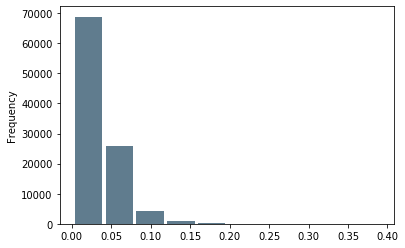

In [44]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,91)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))


 AUC for precision-recall : 0.07493748036901846


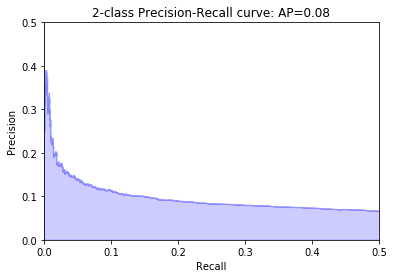

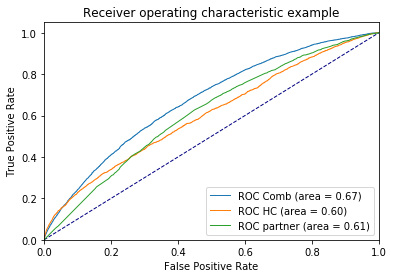

In [45]:
## PRC curve
precision, recall, _ = precision_recall_curve(y_test, ypred_test_pillar)

step_kwargs = ({'step': 'post'}
               #if 'step' in signature(plt.fill_between).parameters
               #else {}
              )
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 0.5])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# calculate precision-recall AUC
auc_pr = auc(recall, precision)
print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(test['RISK_FSTQPD30'], test['HC_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [46]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 23.17%

Total bads in test sample: 3647
                      pred       act
pred                                
(0.0009, 0.0141]  0.010992  0.009895
(0.0141, 0.0184]  0.016296  0.013195
(0.0184, 0.0222]  0.020293  0.019092
(0.0222, 0.0261]  0.024152  0.025590
(0.0261, 0.0303]  0.028162  0.030785
(0.0303, 0.0353]  0.032772  0.034786
(0.0353, 0.0418]  0.038387  0.038485
(0.0418, 0.0507]  0.045896  0.047081
(0.0507, 0.0661]  0.057557  0.061176
(0.0661, 0.391]   0.090044  0.084458
                        pred  act
pred                             
(0.0009, 0.0141]  109.975504   99
(0.0141, 0.0184]  163.023376  132
(0.0184, 0.0222]  203.009715  191
(0.0222, 0.0261]  241.617592  256
(0.0261, 0.0303]  281.760620  308
(0.0303, 0.0353]  327.853200  348
(0.0353, 0.0418]  384.026852  385
(0.0418, 0.0507]  459.144250  471
(0.0507, 0.0661]  575.796121  612
(0.0661, 0.391]   900.888743  845
